# 1) Quick checks

Salaire dispo sur 37% des offres


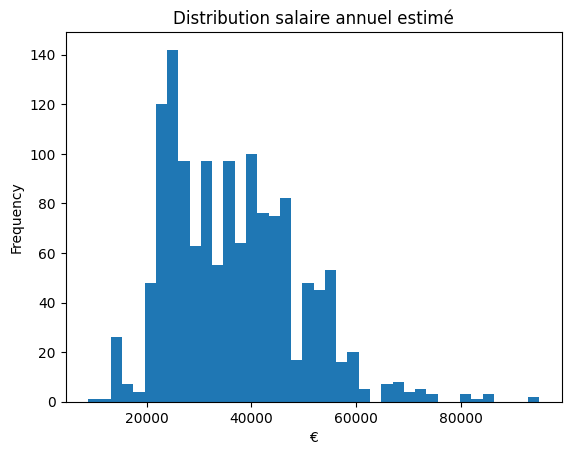

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

CSV_PATH = "/francetravail_salaire_normalise.csv"
df = pd.read_csv(CSV_PATH)

# % de salaires exploitables
pct = df['salaire_annuel_estime'].notna().mean()
print(f"Salaire dispo sur {pct:.0%} des offres")

# distribution (pour repérer les anomalies restantes)
df['salaire_annuel_estime'].dropna().plot(kind='hist', bins=40)
plt.title("Distribution salaire annuel estimé"); plt.xlabel("€"); plt.show()

# 2) Préparer les features pour le clustering

In [5]:
# Colonnes utiles si présentes (le code est robuste aux absences)
has = df.columns
pick = lambda name: name if name in has else None

cols_cat = [c for c in [
    'typeContrat','natureContrat',
    'secteurActiviteLibelle','experienceExige','romeLibelle'
] if pick(c)]

cols_num = [c for c in ['nombrePostes'] if pick(c)]
cols_geo = [c for c in ['codePostal'] if pick(c)]

# département (2 premiers caractères de codePostal), sinon "NA"
if 'codePostal' in df:
    dep = df['codePostal'].astype(str).str[:2]
    df['dep'] = dep.where(dep.str.fullmatch(r'\d{2}'), np.nan).fillna('NA')
    cols_cat.append('dep')

# bornage simple nombrePostes
if 'nombrePostes' in df:
    df['nombrePostes'] = np.where((df['nombrePostes']>=1) & (df['nombrePostes']<=50),
                                  df['nombrePostes'], 1)

features = cols_cat + cols_num
print("Catégorielles:", cols_cat)
print("Numériques:", cols_num)

Catégorielles: ['typeContrat', 'natureContrat', 'secteurActiviteLibelle', 'experienceExige', 'romeLibelle']
Numériques: ['nombrePostes']


# 3) Pipeline scikit-learn (OneHot + StandardScaler + KMeans)

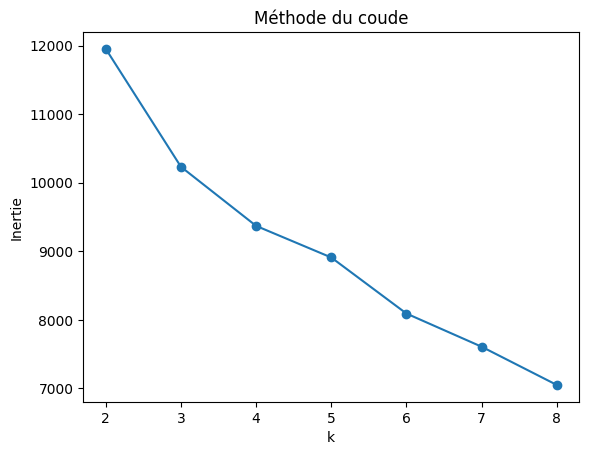

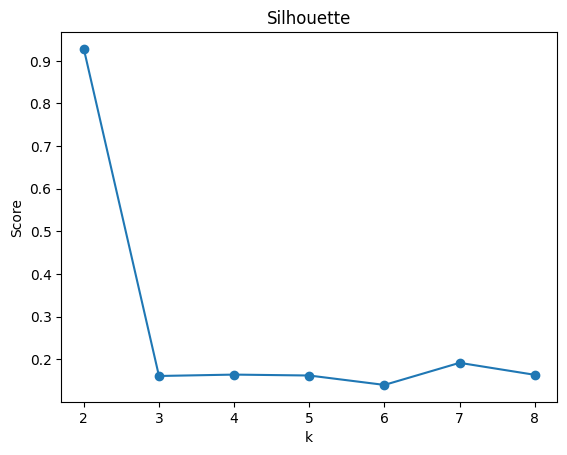

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

X = df[features].copy()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cols_cat),
        ("num", StandardScaler(), cols_num)
    ],
    remainder="drop"
)

# Coude + silhouette pour choisir k
inertias, sils, ks = [], [], range(2, 9)
for k in ks:
    pipe = Pipeline([
        ("prep", preprocess),
        ("km", KMeans(n_clusters=k, n_init=20, random_state=42))
    ])
    Xt = pipe.named_steps['prep'].fit_transform(X)
    km = KMeans(n_clusters=k, n_init=20, random_state=42).fit(Xt)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Xt, km.labels_))

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(list(ks), inertias, marker='o'); ax.set_title("Méthode du coude"); ax.set_xlabel("k"); ax.set_ylabel("Inertie"); plt.show()

fig, ax = plt.subplots()
ax.plot(list(ks), sils, marker='o'); ax.set_title("Silhouette"); ax.set_xlabel("k"); ax.set_ylabel("Score"); plt.show()

# 4) Entraîner le modèle et affecter les clusters

In [7]:
k = 3  # ← ajuste selon les deux courbes au-dessus
pipe = Pipeline([
    ("prep", preprocess),
    ("km", KMeans(n_clusters=k, n_init=30, random_state=42))
])
pipe.fit(X)
df['cluster'] = pipe.named_steps['km'].labels_.astype(int)
print(df['cluster'].value_counts().sort_index())

cluster
0    2580
1    1156
2       4
Name: count, dtype: int64


# 5) Profiler/interpréter les clusters

In [9]:
# Taille + salaire (a posteriori, pour info)
prof_num = df.groupby('cluster').agg(
    n=('cluster','size'),
    salaire_median=('salaire_annuel_estime','median'),
    salaire_p25=('salaire_annuel_estime', lambda s: s.dropna().quantile(0.25)),
    salaire_p75=('salaire_annuel_estime', lambda s: s.dropna().quantile(0.75))
).sort_values('n', ascending=False)
print(prof_num)

# Top modalités par variable catégorielle
def top_modalites(col, top=3):
    # Comptages par cluster x modalité
    counts = (df
              .groupby(['cluster', col], dropna=False, as_index=False)
              .size()
              .rename(columns={'size':'n'}))
    # Pourcentages intra-cluster
    counts['pct'] = counts['n'] / counts.groupby('cluster')['n'].transform('sum')
    # Top-k par cluster
    topk = (counts
            .sort_values(['cluster', 'pct'], ascending=[True, False])
            .groupby('cluster', as_index=False)
            .head(top))
    return topk[['cluster', col, 'pct']]

for c in cols_cat:
    if c in df.columns:
        print(f"\n=== {c} ===")
        print(top_modalites(c, top=3))

            n  salaire_median  salaire_p25  salaire_p75
cluster                                                
0        2580         37500.0      30000.0      47500.0
1        1156         25227.0      22204.0      33503.0
2           4         22440.6      22440.6      22595.3

=== typeContrat ===
    cluster typeContrat       pct
2         0         CDI  0.820543
5         0         MIS  0.081395
1         0         CDD  0.074031
7         1         CDI  0.700692
6         1         CDD  0.205017
11        1         MIS  0.074394
14        2         MIS  0.750000
13        2         CDI  0.250000

=== natureContrat ===
    cluster                   natureContrat       pct
4         0                 Contrat travail  0.965891
5         0              Emploi non salarié  0.023256
0         0  CDI de chantier ou d'opération  0.004264
9         1                 Contrat travail  0.855536
8         1           Contrat apprentissage  0.121972
10        1              Emploi non salarié  0

Codification experience : D = débutant accepté, S = expérience souhaitée, E = expérience exigée

**L’analyse de classification non supervisée (K-Means, k = 3) a permis d’identifier trois profils distincts d’offres d’emploi dans le jeu de données France Travail.**

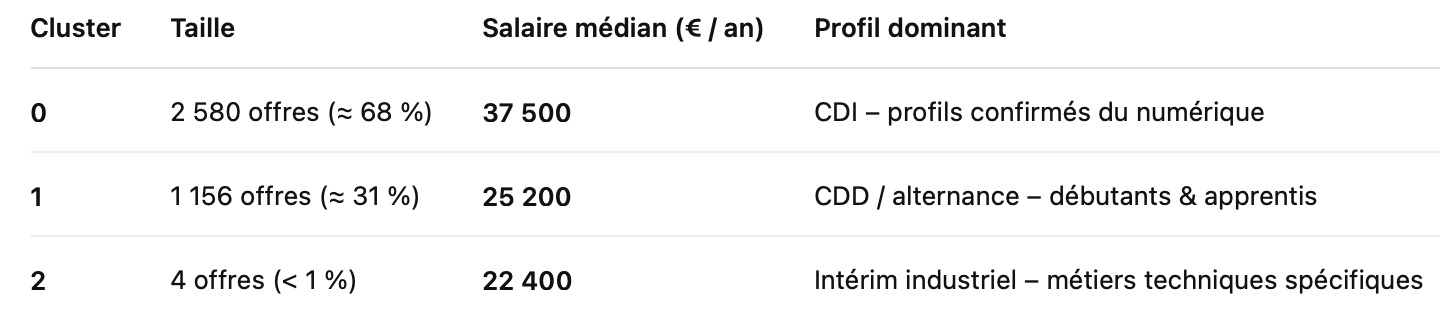

### Cluster 0 — CDI expérimentés en informatique


	*	Type de contrat : 82 % CDI
	*	Nature du contrat : 96 % “Contrat de travail”
	*	Expérience : exigée pour 88 % des offres
	*	Métiers dominants : développeur informatique, développeur web, chef de projet MOA
	*	Secteurs représentés : conseil, SSII, agences d’intérim IT
	*	Profil résumé : postes stables, qualifiés et bien rémunérés pour professionnels confirmés du numérique.

### Cluster 1 — CDD et alternance : profils en entrée de carrière

	*	Type de contrat : 70 % CDI, 20 % CDD, 12 % apprentissage
	*	Expérience : 98 % “débutant accepté”
	*	Métiers dominants : développeur web, ingénieur d’études, scrum master
	*	Secteurs : majoritairement IT / développement web
	*	Profil résumé : emplois de transition ou de formation, salaires plus faibles, population jeune diplômée.

### Cluster 2 — Intérim industriel et métiers techniques rares

	*	Type de contrat : 75 % missions d’intérim (MIS)
	*	Secteurs : industrie et travail temporaire
	*	Métiers : câbleur d’armoires électriques, administrateur de serveurs
	*	Profil résumé : groupe marginal et atypique, peu représentatif du cœur de l’échantillon (probable cluster d’outliers).

# 6) Visualisation 2D (PCA)

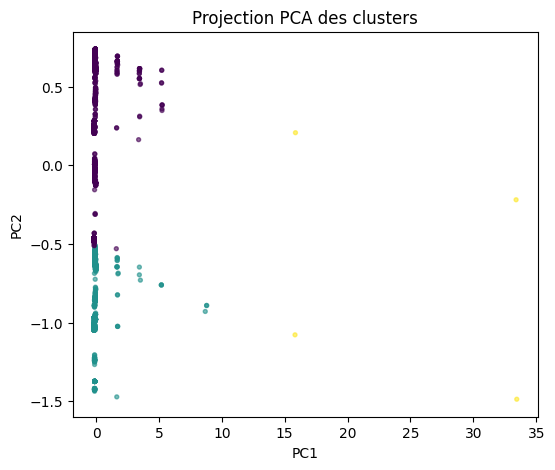

In [10]:
from sklearn.decomposition import PCA

Xt = pipe.named_steps['prep'].transform(X)
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xt)

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=df['cluster'], s=8, alpha=0.6)
plt.title("Projection PCA des clusters")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

### **Interprétation visuelle du graphique**

** Deux groupes denses à gauche **

La majorité des points sont très regroupés près de 0–5
sur PC1 → cela signifie que :

*	les clusters 0 et 1 ont des profils proches sur la plupart des variables,
*	mais ils se différencient sur quelques dimensions clés (probablement type de contrat ou expérience).

👉 Cela est cohérent car :

*	Cluster 0 : CDI expérimentés
*	Cluster 1 : débutants / alternance

**Ils partagent des métiers similaires (développement web) mais diffèrent sur la stabilité du contrat et l’expérience.**

Quelques points isolés à droite (PC1 ≈ 15–35)

* Ces points appartiennent clairement au Cluster 2 (couleur distincte, jaune ici).

* Ils sont éloignés des autres → ce sont des outliers ou des profils atypiques (peu représentés dans les variables principales).

**PC1 **(axe horizontal) semble capturer le type de contrat + la nature du métier :
* valeurs faibles → emplois IT classiques (clusters 0 & 1)
* valeurs fortes → métiers industriels (cluster 2)

**PC2 **(axe vertical) capte peut-être le niveau d’expérience ou la forme du contrat (CDD/CDI).